# How to Perform a Complete Investment Drawdown Analysis in Python

By: Cordell L. Tanny, CFA, FRM, FDP
July 26, 2024

All code is provided by Digital Hub Insights. If this code is used in your projects, please cite Digital Hub Insights as the source.

In [22]:
!pip install pandas_market_calendars
import pandas as pd
import pandas_market_calendars as mcal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

pd.set_option('mode.chained_assignment', None)
sns.set()

In [14]:
# Functions
def retrieve_prices_yf(tickers: list, start_date: str, end_date: str, frequency: str = 'D', common_inception: bool = False) -> pd.DataFrame:
    """
    Retrieve adjusted close prices for given investment tickers within a specified date range, resampled to a specified frequency.

    Params:
    tickers (list): A list of investment ticker symbols.
    start_date (str): The start date for the price data in 'YYYY-MM-DD' format.
    end_date (str): The end date for the price data in 'YYYY-MM-DD' format.
    frequency (str): The frequency for resampling the data. 'D' for daily (default), 'W' for weekly, and 'M' for monthly.
    common_inception (bool): If True, only returns dates where all tickers have data. Defaults to False.

    Returns:
    pd.DataFrame: A DataFrame with adjusted close prices resampled to the specified frequency.

    Raises:
    ValueError: If tickers are not provided in a list of strings.

    Example:
    >>> retrieve_prices(['AAPL', 'MSFT'], '2020-01-01', '2020-12-31', 'W')
    """

    # Validate tickers input
    if not isinstance(tickers, list) or not all(isinstance(ticker, str) for ticker in tickers):
        raise ValueError('Please supply tickers in a list of strings')

    # Retrieve the pricing data using yfinance
    df_prices = yf.download(tickers, start_date, end_date)['Adj Close']

    # Resample data based on the frequency
    if frequency == 'W':
        df_prices = df_prices.resample('W-FRI').last()
    elif frequency == 'M':
        df_prices = df_prices.resample('M').last()

    # Remove all rows containing NaN if common_inception is True
    if common_inception:
        df_prices.dropna(inplace=True)

    return df_prices


def max_drawdown(returns: pd.DataFrame):
    """
    Calculates the maximum drawdown for each financial instrument in a DataFrame.

    A drawdown is the peak-to-trough decline during a specific recorded period of an investment.
    This function computes the maximum drawdown, which is the maximum observed loss from a peak to
    a trough of a portfolio, before a new peak is attained. It is particularly useful for assessing
    the financial risk of an investment.

    Parameters:
    returns (pd.DataFrame): A DataFrame where each column represents a different financial instrument
                            and contains their respective monthly returns.

    Returns:
    pd.DataFrame: A DataFrame where each row corresponds to a financial instrument from the input,
                  and contains its maximum drawdown as a percentage.
    """
    # Initialize DataFrame to store maximum drawdowns
    max_drawdowns = pd.DataFrame(dtype=float, columns=returns.columns)

    # Calculate maximum drawdown for each column (financial instrument)
    for column in returns.columns:
        # Cumulative returns from the beginning of the time series
        cumulative_returns = (1 + returns[column]).cumprod()

        # Track the highest value (peak) reached so far in cumulative returns
        previous_peaks = cumulative_returns.cummax()

        # Calculate drawdowns as the percentage loss from the previous peak
        drawdowns = (cumulative_returns - previous_peaks) / previous_peaks.shift(1)

        # Identify the maximum drawdown
        max_drawdown = drawdowns.min()
        max_drawdowns.loc[0, column] = max_drawdown

    # Rename the index for clarity
    max_drawdowns.index = ['Maximum Drawdown']

    # Return the result, converting drawdowns to percentage format
    return np.round(max_drawdowns.mul(100), 2).T


def drawdown_graph(returns, add_watermark=False):
    """
    Generate a line graph for drawdowns using matplotlib and seaborn.

    Args:
    returns (pd.DataFrame): A DataFrame where each column represents the daily returns of different assets.

    Returns:
    None: This function does not return a value. It displays a line graph showing the drawdowns.

    Description:
    This function calculates the drawdowns from the cumulative returns of the assets and plots them.
    A drawdown is the peak-to-trough decline during a specific period for an investment. It is expressed as a percentage between the peak and the trough.

    Example:
    >>> returns = pd.DataFrame({
            'Asset1': [0.01, -0.02, 0.03, -0.04, 0.01],
            'Asset2': [0.02, -0.01, 0.01, -0.03, 0.02]
        }, index=pd.date_range(start='2020-01-01', periods=5))
    >>> drawdown_graph(returns)
    """

    # Calculate cumulative returns from daily returns
    cumulative_returns = (1 + returns).cumprod()

    # Determine the running maximum of the cumulative returns to date
    previous_peaks = cumulative_returns.cummax()

    # Calculate drawdowns as the percentage drop from the previous peak
    drawdowns = (cumulative_returns - previous_peaks) / previous_peaks.shift(1)

    # Fill any missing values with 0 and convert drawdowns to percentage format
    drawdowns = drawdowns.fillna(0).mul(100).round(2)

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plot each column in the drawdowns DataFrame
    for column in drawdowns.columns:
        sns.lineplot(data=drawdowns[column], ax=ax, label=column)

    # Labeling the axes and the plot
    ax.set_xlabel('Date')
    ax.set_ylabel('Drawdown (%)')
    ax.set_title('Drawdown Analysis')

    legend = ax.legend(frameon=False)

    # Display the plot
    plt.show()


def drawdown_complete(fund_returns, threshold):
    """
    Calculate drawdowns for a given set of fund returns and a threshold.

    Parameters:
    fund_returns (pd.DataFrame): DataFrame with fund returns, where each column represents a fund.
    threshold (float): Threshold for drawdown percentage. Drawdowns greater than this threshold will be recorded.

    Returns:
    pd.DataFrame: DataFrame with drawdown details for each fund, filtered by the threshold.
    """
    # Initialize list to hold individual fund drawdown DataFrames
    df_list = []
    threshold = threshold / 100  # Convert threshold to decimal

    for fund in fund_returns.columns:
        # Calculate wealth index and previous peaks
        wealth_index = 1000 * (1 + fund_returns[fund]).cumprod()
        previous_peaks = wealth_index.cummax()
        drawdowns = ((wealth_index - previous_peaks) / previous_peaks)

        # Create a temporary DataFrame to hold wealth, peaks, and drawdown
        df_temp = pd.DataFrame({
            'Wealth': wealth_index,
            'Peaks': previous_peaks,
            'Drawdown': drawdowns
        })

        df = pd.DataFrame()
        i = 0

        while i <= (len(df_temp) - 1):
            if df_temp.iloc[i, 0] < df_temp.iloc[i, 1]:
                begin_date = df_temp.index[i - 1]
                peak_value = df_temp.iloc[i, 1]
                bottom_date = df_temp.index[i]
                bottom_value = df_temp.iloc[i, 0]

                ongoing_drawdown = True

                for j in range(i, len(df_temp)):
                    if df_temp.iloc[j, 0] <= bottom_value:
                        bottom_date = df_temp.index[j]
                        bottom_value = df_temp.iloc[j, 0]
                    elif df_temp.iloc[j, 0] >= peak_value:
                        end_date = df_temp.index[j]
                        i = j
                        ongoing_drawdown = False
                        # Update current drawdown information
                        temp_dict = {
                            'Begin Date': begin_date.strftime('%Y-%m-%d'),
                            'Trough Date': bottom_date.strftime('%Y-%m-%d'),
                            'End Date': end_date.strftime('%Y-%m-%d'),
                            'Peak Value': peak_value,
                            'Bottom Value': bottom_value,
                            'Drawdown %': (bottom_value / peak_value - 1) * 100
                        }
                        df = pd.concat([df, pd.DataFrame([temp_dict])], ignore_index=True)
                        break
                    elif j == len(df_temp) - 1:
                        ongoing_drawdown = True

                if ongoing_drawdown:
                    # Handle ongoing drawdown
                    temp_dict = {
                        'Begin Date': begin_date.strftime('%Y-%m-%d'),
                        'Trough Date': bottom_date.strftime('%Y-%m-%d'),
                        'End Date': np.nan,
                        'Peak Value': peak_value,
                        'Bottom Value': bottom_value,
                        'Drawdown %': (bottom_value / peak_value - 1) * 100
                    }
                    df = pd.concat([df, pd.DataFrame([temp_dict])], ignore_index=True)
                    i = j

            i += 1

        # Reorder columns
        cols = ['Begin Date', 'Trough Date', 'End Date', 'Peak Value', 'Bottom Value', 'Drawdown %']
        df = df.reindex(columns=cols)
        df['Fund'] = fund

        # Filter by drawdown threshold
        df = df[df['Drawdown %'] <= -threshold * 100]
        df_list.append(df)

    # Create final DataFrame
    df_final = pd.concat(df_list)
    df_final.set_index('Fund', inplace=True)

    return df_final.round(2)


def single_fund_drawdown_stats(fund, fund_returns, threshold=10):
    """
    Analyzes and returns the drawdown statistics for a specified fund within a given time frame.

    Parameters
    ----------
    fund : str
        The ticker symbol of the fund to analyze.
    fund_returns : pd.DataFrame
        A DataFrame containing the returns of the selected funds.
    threshold : float
        The minimum percentage drop to consider as a drawdown (e.g., 10 for 10%).

    Returns
    -------
    pd.DataFrame
        A DataFrame with drawdown analysis results for the specified fund.
    """

    # Generate complete drawdown statistics
    df_draw = drawdown_complete(fund_returns, threshold=threshold)

    try:
        # Isolate the specific fund's data
        df_fund = df_draw.loc[fund]

        # Convert Series to DataFrame if necessary
        df_fund = df_fund.to_frame().T if isinstance(df_fund, pd.Series) else df_fund
        df_fund['Drawdown %'] = df_fund['Drawdown %'].astype(float)

        # Convert date columns to datetime format
        time_columns = ['Begin Date', 'Trough Date', 'End Date']
        df_fund[time_columns] = df_fund[time_columns].apply(pd.to_datetime)

        # Calculate durations between dates
        df_fund['Time to Trough'] = df_fund.apply(
            lambda row: (row['Trough Date'] - row['Begin Date']).days
            if pd.notna(row['Trough Date']) else np.nan, axis=1)

        df_fund['Trough to Recovery'] = df_fund.apply(
            lambda row: (row['End Date'] - row['Trough Date']).days
            if pd.notna(row['End Date']) else np.nan, axis=1)

        df_fund['Total Duration'] = df_fund.apply(
            lambda row: (row['End Date'] - row['Begin Date']).days
            if pd.notna(row['End Date']) else np.nan, axis=1)

        cols = [
            'Begin Date', 'Trough Date', 'End Date', 'Time to Trough', 'Trough to Recovery', 'Total Duration',
            'Drawdown %',
        ]
        cols = [col for col in cols if col is not None]  # Remove None values

        df_final = df_fund[cols].reset_index(drop=True)

        # convert date columns to string
        df_final['Begin Date'] = df_final['Begin Date'].dt.strftime('%Y-%m-%d')
        df_final['Trough Date'] = df_final['Trough Date'].dt.strftime('%Y-%m-%d')
        df_final['End Date'] = df_final['End Date'].dt.strftime('%Y-%m-%d')

        return df_final

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error



In [6]:
tickers = ['QQQ', 'SPY', 'DIA', 'IWM']
start_date = '1999-03-10'
end_date = '2024-07-25'

# retrieve the prices
df_prices = retrieve_prices_yf(tickers, start_date, end_date, 'D')
df_prices.index = pd.to_datetime(df_prices.index)

# convert the prices to returns
df_returns = df_prices.pct_change().dropna()
df_rets_monthly = df_prices.resample('M').last().pct_change().dropna()

threshold = 10

[*********************100%%**********************]  4 of 4 completed


In [13]:
maximum_drawdown = max_drawdown(df_returns)
maximum_drawdown

,Maximum Drawdown
Ticker,
DIA,-51.87
IWM,-58.64
QQQ,-80.45
SPY,-55.19


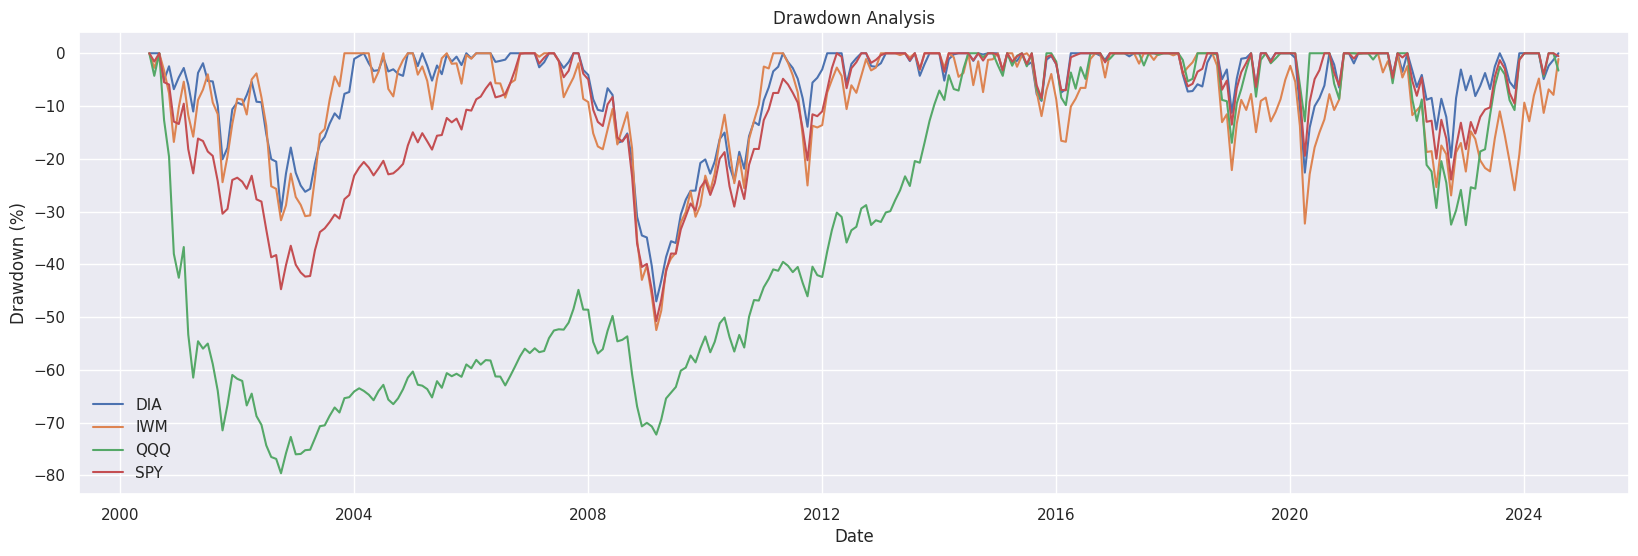

In [17]:
drawdown_graph(df_rets_monthly)

In [26]:
# Analysis of qqq

df_prices_qqq = retrieve_prices_yf(['QQQ'], start_date, end_date)
df_prices_qqq.index = pd.to_datetime(df_prices_qqq.index)

# convert the prices to returns
df_returns_qqq = df_prices_qqq.pct_change().dropna().to_frame(name='QQQ')
df_rets_qqq_monthly = df_prices.resample('M').last().pct_change().dropna()

drawdown_stats = single_fund_drawdown_stats('QQQ', df_returns_qqq,
                                            threshold=threshold)
drawdown_stats

[*********************100%%**********************]  1 of 1 completed


,Begin Date,Trough Date,End Date,Time to Trough,Trough to Recovery,Total Duration,Drawdown %
0,1999-04-09,1999-04-19,1999-04-26,10,7,17,-11.25
1,1999-04-26,1999-05-25,1999-06-21,29,27,56,-11.91
2,1999-07-16,1999-08-10,1999-08-25,25,15,40,-11.81
3,2000-01-03,2000-01-06,2000-01-19,3,13,16,-15.47
4,2000-01-21,2000-01-28,2000-02-03,7,6,13,-10.65
5,2000-03-09,2000-03-15,2000-03-23,6,8,14,-10.54
6,2000-03-27,2002-10-09,2015-02-20,926,4517,5443,-82.96
7,2015-07-20,2015-08-25,2015-10-28,36,64,100,-13.94
8,2015-12-01,2016-02-09,2016-07-27,70,169,239,-16.10
9,2018-01-26,2018-02-08,2018-03-09,13,29,42,-10.23


In [27]:
drawdown_stats_monthly = single_fund_drawdown_stats('QQQ', df_rets_monthly, threshold=threshold)
drawdown_stats_monthly

,Begin Date,Trough Date,End Date,Time to Trough,Trough to Recovery,Total Duration,Drawdown %
0,2000-08-31,2002-09-30,2014-06-30,760,4291,5051,-79.61
1,2018-08-31,2018-12-31,2019-04-30,122,120,242,-16.97
2,2020-01-31,2020-03-31,2020-04-30,60,30,90,-12.90
3,2021-12-31,2022-12-31,2023-12-31,365,365,730,-32.58
